In [1]:
!pip install kaggle

**Importing the Dependencies**

In [8]:
import os
import json

from zipfile import ZipFile
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

**Data Collection- Kaggle API**

In [9]:
kaggle_dictionary = json.load(open("kaggle.json"))

In [10]:
kaggle_dictionary.keys()

dict_keys(['username', 'key'])

In [11]:
# setup kaggle credentials as environment variables
os.environ["KAGGLE_USERNAME"] = kaggle_dictionary["username"]
os.environ["KAGGLE_KEY"] = kaggle_dictionary["key"]

In [12]:
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
License(s): other
imdb-dataset-of-50k-movie-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
!ls

imdb-dataset-of-50k-movie-reviews.zip  kaggle.json  sample_data


In [13]:
# unzip the dataset file
with ZipFile("imdb-dataset-of-50k-movie-reviews.zip", "r") as zip_ref:
  zip_ref.extractall()

In [15]:
!ls

 drive		     imdb-dataset-of-50k-movie-reviews.zip   sample_data
'IMDB Dataset.csv'   kaggle.json


**Loading teh Dataset**

In [14]:
data = pd.read_csv("/content/IMDB Dataset.csv")

In [11]:
data.shape

(50000, 2)

In [12]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [13]:
data.tail()

,review,sentiment
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative
49999,No one expects the Star Trek movies to be high...,negative


In [22]:
data["sentiment"].value_counts()

,count
sentiment,
1,25000
0,25000


In [15]:
data.replace({"sentiment": {"positive": 1, "negative": 0}}, inplace=True)

<ipython-input-15-c1a779bd745a>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace({"sentiment": {"positive": 1, "negative": 0}}, inplace=True)


In [18]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [24]:
data["sentiment"].value_counts()

,count
sentiment,
1,25000
0,25000


### Numbers of words in the text

In [29]:
import pandas as pd

# Assuming your DataFrame is named train_data
train_data['word_count'] = train_data['review'].apply(lambda x: len(str(x).split()))

In [30]:
train_data[['review', 'word_count']].head()

,review,word_count
39087,That's what I kept asking myself during the ma...,400
30893,I did not watch the entire movie. I could not ...,283
45278,A touching love story reminiscent of In the M...,93
16398,This latter-day Fulci schlocker is a totally a...,174
13653,"First of all, I firmly believe that Norwegian ...",306


In [31]:
train_data['word_count'].describe()

,word_count
count,40000.000000
mean,231.006425
std,171.612227
min,4.000000
25%,126.000000
50%,173.000000
75%,280.000000
max,2470.000000


### Distribution of Number of Words


<Axes: >

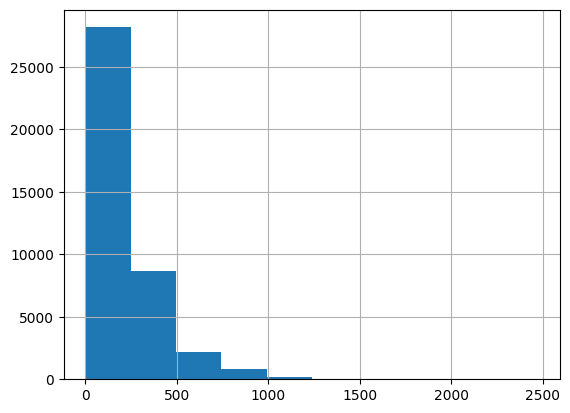

In [32]:
train_data['word_count'].hist()

## Distribution of Positive and Negative by the Number of Words

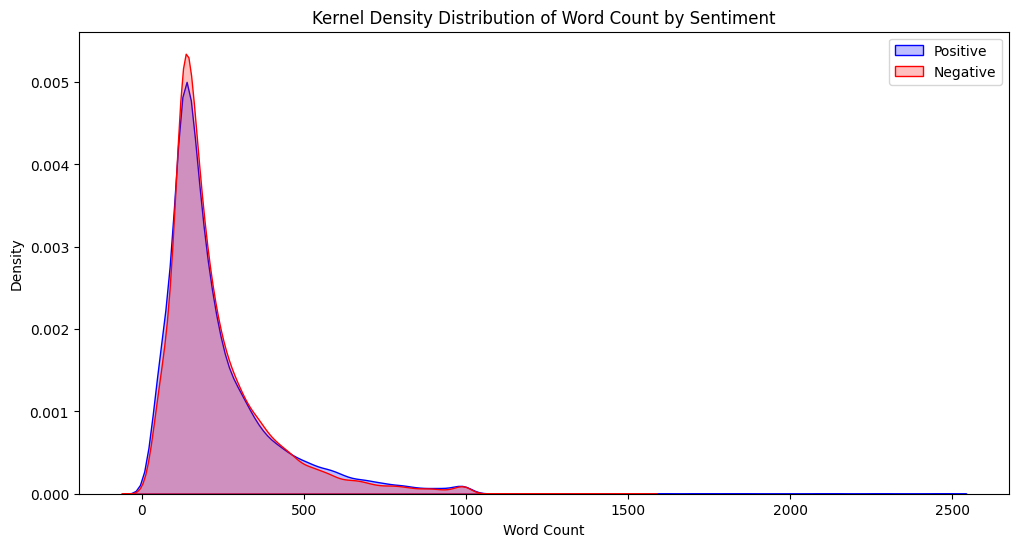

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

# KDE plot for positive sentiment
sns.kdeplot(
    train_data[train_data['sentiment'] == 1]['word_count'],
    fill=True, color="b", label="Positive"
)

# KDE plot for negative sentiment
sns.kdeplot(
    train_data[train_data['sentiment'] == 0]['word_count'],
    fill=True, color="r", label="Negative"
)

plt.title('Kernel Density Distribution of Word Count by Sentiment')
plt.xlabel('Word Count')
plt.ylabel('Density')
plt.legend()
plt.show()


## **Data Cleaning**
 - Lowercasing

- Removing square bracketed text

- Removing URLs

- Removing HTML tags

- Removing punctuation

- Removing newlines (converting to space)

- Removing words with digits

- Removing extra spaces

- Removing stopwords

In [17]:
import re
import string
import nltk
from nltk.corpus import stopwords

# 1. Download stopwords (do this once)
nltk.download('stopwords')

# 2. Get stopword list
stop_words = set(stopwords.words('english'))

# 3. Define clean_text function
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(f"[{re.escape(string.punctuation)}]", '', text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\w*\d\w*', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# 4. Apply to your review data BEFORE tokenization
data['clean_review'] = data['review'].apply(clean_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
# split data into training data and test data
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

In [19]:
print(train_data.shape)
print(test_data.shape)

(40000, 3)
(10000, 3)


**Data Preprocessing**

In [20]:
# Tokenize text data
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_data["review"])
X_train = pad_sequences(tokenizer.texts_to_sequences(train_data["review"]), maxlen=200)
X_test = pad_sequences(tokenizer.texts_to_sequences(test_data["review"]), maxlen=200)

In [43]:
print(X_train)

[[1935    1 1200 ...  205  351 3856]
 [   3 1651  595 ...   89  103    9]
 [   0    0    0 ...    2  710   62]
 ...
 [   0    0    0 ... 1641    2  603]
 [   0    0    0 ...  245  103  125]
 [   0    0    0 ...   70   73 2062]]


In [44]:
print(X_test)

[[   0    0    0 ...  995  719  155]
 [  12  162   59 ...  380    7    7]
 [   0    0    0 ...   50 1088   96]
 ...
 [   0    0    0 ...  125  200 3241]
 [   0    0    0 ... 1066    1 2305]
 [   0    0    0 ...    1  332   27]]


In [21]:
Y_train = train_data["sentiment"]
Y_test = test_data["sentiment"]

In [46]:
print(Y_train)

39087    0
30893    0
45278    1
16398    0
13653    0
        ..
11284    1
44732    1
38158    0
860      1
15795    1
Name: sentiment, Length: 40000, dtype: int64


**LSTM - Long Short-Term Memory**

**Model 1**

In [56]:
# build the model

model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=200))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation="sigmoid"))

In [59]:
model.build(input_shape=(None, 200))  # batch size None, sequence length 200
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 200, 128)       │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 771,713 (2.94 MB)

 Trainable params: 771,713 (2.94 MB)

 Non-trainable params: 0 (0.00 B)

In [60]:
# compile the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

**Training the Model**

In [61]:
model.fit(X_train, Y_train, epochs=5, batch_size=64, validation_split=0.2)

Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 198s 383ms/step - accuracy: 0.7194 - loss: 0.5320 - val_accuracy: 0.8385 - val_loss: 0.3727
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 198s 382ms/step - accuracy: 0.8549 - loss: 0.3507 - val_accuracy: 0.8389 - val_loss: 0.3806
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 199s 377ms/step - accuracy: 0.8716 - loss: 0.3091 - val_accuracy: 0.8626 - val_loss: 0.3289
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 190s 379ms/step - accuracy: 0.8920 - loss: 0.2695 - val_accuracy: 0.8661 - val_loss: 0.3451
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 195s 366ms/step - accuracy: 0.9080 - loss: 0.2367 - val_accuracy: 0.8771 - val_loss: 0.3103


**Metrics for the Model**

In [69]:
target_names = ['negative', 'positive']

print(classification_report(true_labels, predicted_labels, target_names=target_names))


              precision    recall  f1-score   support

    negative       0.50      1.00      0.66      4961
    positive       0.00      0.00      0.00      5039

    accuracy                           0.50     10000
   macro avg       0.25      0.50      0.33     10000
weighted avg       0.25      0.50      0.33     10000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [70]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(true_labels, predicted_labels)
print(conf_matrix)


[[4961    0]
 [5039    0]]


**Model Evaluation**

In [ ]:
loss, accuracy = model.evaluate(X_test, Y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

313/313 [==============================] - 20s 63ms/step - loss: 0.3139 - accuracy: 0.8830
Test Loss: 0.313868910074234
Test Accuracy: 0.8830000162124634


**Model 2 - Bidirectional LSTM**

In [105]:
model = Sequential([
    Embedding(12000, 100, input_length=200),
    SpatialDropout1D(0.2),
    Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [107]:
import numpy as np

Y_train = np.array(Y_train).reshape(-1, 1).astype('float32')
Y_test = np.array(Y_test).reshape(-1, 1).astype('float32')


In [109]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

model.fit(
    X_train, Y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_test, Y_test),
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 432s 691ms/step - accuracy: 0.8541 - loss: 0.3421 - val_accuracy: 0.8459 - val_loss: 0.3468 - learning_rate: 0.0010
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 444s 695ms/step - accuracy: 0.8845 - loss: 0.2817 - val_accuracy: 0.8688 - val_loss: 0.3027 - learning_rate: 0.0010
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 429s 674ms/step - accuracy: 0.8964 - loss: 0.2567 - val_accuracy: 0.8690 - val_loss: 0.3097 - learning_rate: 0.0010
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 430s 688ms/step - accuracy: 0.9139 - loss: 0.2197 - val_accuracy: 0.8843 - val_loss: 0.3024 - learning_rate: 0.0010
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 443s 689ms/step - accuracy: 0.9132 - loss: 0.2182 - val_accuracy: 0.8934 - val_loss: 0.2659 - learning_rate: 0.0010
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 452s 706ms/step - accuracy: 0.9321 - loss: 0.1741 - val_accuracy: 0.8972 - val_loss: 0.2771 - learning_rate: 0.0010
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 430s 686ms/step - accura

In [112]:
# Get new predictions
predictions = model.predict(X_test)
predicted_labels = (predictions > 0.5).astype('int').flatten()
true_labels = Y_test.flatten().astype('int')

from sklearn.metrics import classification_report, confusion_matrix

# Evaluate
target_names = ['negative', 'positive']
print(classification_report(true_labels, predicted_labels, target_names=target_names))
print("Confusion Matrix:")
print(confusion_matrix(true_labels, predicted_labels))


313/313 ━━━━━━━━━━━━━━━━━━━━ 68s 214ms/step
              precision    recall  f1-score   support

    negative       0.89      0.90      0.89      4961
    positive       0.90      0.89      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

Confusion Matrix:
[[4454  507]
 [ 559 4480]]


In [113]:
loss, accuracy = model.evaluate(X_test, Y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 66s 212ms/step - accuracy: 0.8917 - loss: 0.2692
Test Loss: 0.2658678889274597
Test Accuracy: 0.8934000134468079


## **Model 3 - Bidirectional GRU**

In [114]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, Bidirectional, GRU, Dense

model = Sequential([
    Embedding(12000, 100, input_length=20),
    SpatialDropout1D(0.2),
    Bidirectional(GRU(128, dropout=0.2, recurrent_dropout=0.2)),
    Dense(1, activation='sigmoid')  # Output for binary classification
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(
    X_train, Y_train,
    epochs=10,
    validation_data=(X_test, Y_test),
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 840s 668ms/step - accuracy: 0.7150 - loss: 0.5326 - val_accuracy: 0.8847 - val_loss: 0.2836 - learning_rate: 0.0010
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 842s 652ms/step - accuracy: 0.8968 - loss: 0.2607 - val_accuracy: 0.9029 - val_loss: 0.2430 - learning_rate: 0.0010
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 872s 660ms/step - accuracy: 0.9233 - loss: 0.1954 - val_accuracy: 0.9053 - val_loss: 0.2368 - learning_rate: 0.0010
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 820s 656ms/step - accuracy: 0.9401 - loss: 0.1602 - val_accuracy: 0.8982 - val_loss: 0.2502 - learning_rate: 0.0010
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 826s 661ms/step - accuracy: 0.9488 - loss: 0.1383 - val_accuracy: 0.8961 - val_loss: 0.2676 - learning_rate: 0.0010
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 858s 658ms/step - accuracy: 0.9652 - loss: 0.1012 - val_accuracy: 0.8940 - val_loss: 0.3141 - learning_rate: 5.0000e-04


In [115]:
from sklearn.metrics import confusion_matrix, classification_report

# Get predicted probabilities
predictions = model.predict(X_test)

# Convert probabilities to binary labels
predicted_labels = (predictions > 0.5).astype(int).flatten()

# Ensure true labels are also flat and integers
true_labels = Y_test.astype(int).flatten()

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
target_names = ['negative', 'positive']
print("\nClassification Report:")
report = classification_report(true_labels, predicted_labels, target_names=target_names)
print(report)


313/313 ━━━━━━━━━━━━━━━━━━━━ 62s 198ms/step
Confusion Matrix:
[[4563  398]
 [ 549 4490]]

Classification Report:
              precision    recall  f1-score   support

    negative       0.89      0.92      0.91      4961
    positive       0.92      0.89      0.90      5039

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



In [116]:
loss, accuracy = model.evaluate(X_test, Y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 62s 197ms/step - accuracy: 0.9049 - loss: 0.2375
Test Loss: 0.2367720901966095
Test Accuracy: 0.9053000211715698


In [27]:
model.save('GRU.h5')

NameError: name 'model' is not defined

## Saving the files on Colab drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Save the Tokenizer as JSON


In [2]:
# Convert tokenizer to JSON
tokenizer_json = tokenizer.to_json()

# Specify your save path, e.g., Google Drive folder
save_path = '/content/drive/MyDrive/deeplearning/'

# Make sure the directory exists
import os
os.makedirs(save_path, exist_ok=True)

# Save tokenizer JSON
with open(save_path + 'tokenizer.json', 'w') as f:
    f.write(tokenizer_json)


## 2. Save the Model

In [4]:
# Save the model in HDF5 format
model.save(save_path + 'model3_GRU.h5')


NameError: name 'train_data' is not defined

## 3. Deploy (Load later for inference)

In [5]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import tokenizer_from_json
import json

# Load tokenizer
with open(save_path + 'tokenizer.json') as f:
    data = json.load(f)
    tokenizer = tokenizer_from_json(data)

# Load model
model = load_model(save_path + 'model3_GRU.h5')


NameError: name 'tokenizer' is not defined

## 4. Example: Using tokenizer and model for prediction

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

MAX_SEQUENCE_LENGTH = 200  # Same max length used in training

def preprocess_text(text):
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
    return padded

def predict(text):
    processed = preprocess_text(text)
    pred = model.predict(processed)
    return 'Positive' if pred > 0.5 else 'Negative'

# Example usage
print(predict("I love this product!"))


**Building a Predictive System**

In [6]:
def predict_sentiment(review):
  # tokenize and pad the review
  sequence = tokenizer.texts_to_sequences([review])
  padded_sequence = pad_sequences(sequence, maxlen=200)
  prediction = model.predict(padded_sequence)
  sentiment = "positive" if prediction[0][0] > 0.5 else "negative"
  return sentiment

In [7]:
# example usage
new_review = "This movie was fantastic. I loved it."
sentiment = predict_sentiment(new_review)
print(f"The sentiment of the review is: {sentiment}")

NameError: name 'tokenizer' is not defined

In [73]:
# example usage
new_review = "This movie was not that good"
sentiment = predict_sentiment(new_review)
print(f"The sentiment of the review is: {sentiment}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
The sentiment of the review is: negative


In [77]:
# example usage
new_review = "This movie was ok but not that good."
sentiment = predict_sentiment(new_review)
print(f"The sentiment of the review is: {sentiment}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
The sentiment of the review is: negative


In [88]:
# example usage
new_review = "no."
sentiment = predict_sentiment(new_review)
print(f"The sentiment of the review is: {sentiment}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
The sentiment of the review is: positive


## Hyperparameter Tuning

In [26]:
!pip install -U scikeras scikit-learn tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 76.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 84.7 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorboard-2.18.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.18.0
    Uninstalling tensorflow-2.18.0:
      Successfully uninstalled tensorflow-2.18.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.11.0 requires tensorflow==2.18.0, but you have tens

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np

# Define the model-building function
def create_model(units=64, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential([
        Embedding(input_dim=12000, output_dim=100, input_length=200),
        SpatialDropout1D(dropout_rate),
        GRU(units, dropout=dropout_rate, recurrent_dropout=dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Wrap the model for use in scikit-learn
model = KerasClassifier(model=create_model, verbose=0)

# Define the hyperparameter grid
param_grid = {
    'model__units': [64, 128],
    'model__dropout_rate': [0.2, 0.4],
    'model__learning_rate': [0.001, 0.0005],
    'batch_size': [64],
    'epochs': [3]  # Increase this for better results
}

# Grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=2)
grid_result = grid.fit(X_train, Y_train)

# Print best result
print("Best score: {:.4f} using {}".format(grid_result.best_score_, grid_result.best_params_))


NameError: name 'X_train' is not defined

In [25]:
# Setup grid search

from sklearn.model_selection import GridSearchCV

model = KerasClassifier(model=create_model, verbose=0)

param_grid = {
    'model__units': [64, 128],
    'model__dropout_rate': [0.2, 0.4],
    'model__learning_rate': [0.001, 0.0005],
    'batch_size': [64, 128],
    'epochs': [3]  # Use more in practice
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=2)

grid_result = grid.fit(X_train, Y_train)


AttributeError: 'super' object has no attribute '__sklearn_tags__'

In [ ]:
print("Best Score: ", grid_result.best_score_)
print("Best Params: ", grid_result.best_params_)